## Elementary Examples in Inverse Dynamics

Falk Mielke, FunMorph, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/ID_LMX4_Arm.ipynb?download&target=_blank).

*[actually posted on 2020/09/14]*

This is one part of a series of blog posts on Inverse Dynamics.
- [Prologue A: Wrench Town Rock](../id_lmx0a_wrenches)
- [Prologue B: The Fictitious Force Awakens](../id_lmx0b_fforces)
- [Elementary Example 1: Stuttering Motor (Euler Force)](../id_lmx1_stutter)
- [Elementary Example 2: Needle On A Vinyl (Centrifugal Force)](../id_lmx2_vinyl)
- [Elementary Example 3: Radial Slider (Coriolis Force)](../id_lmx3_slider)
- [Elementary Example 4: D'Alambert's Arm (D'Alambert Force)](../id_lmx4_arm)
- [Application: N-Link Inverse Dynamics](../id_lmx5_nlink)

In [1]:
import numpy as NP # numerics
import sympy as SYM # symbolic operations
import sympy.physics.mechanics as MECH # some physics/mechanics tools
import matplotlib.pyplot as MPP # plotting

import WrenchToolbox as WT # contains an improved "Wrench" object

# printing of formulas
SYM.init_printing(use_latex='mathjax', pretty_print = False)
MECH.init_vprinting(use_latex='mathjax', pretty_print = False)

# to disable a current sympy/lambdify/numpy hiccup
from warnings import filterwarnings
filterwarnings('ignore', category=NP.VisibleDeprecationWarning)


# shorthand to get the basis of a reference frame
GetCoordinates = lambda rf: [rf[idx] for idx in rf.indices]

# transforming a sympy vector to a matrix
MatrixToVector = lambda mat, rf: sum([elm * base for elm, base in zip(mat, GetCoordinates(rf)) ])


# Steiner's Theorem, generalized form 
# [modern robotics, page 245]
GeneralizedSteiner = lambda mass, columnvector: \
                        SYM.simplify( \
                             mass * ( (columnvector.T*columnvector)[0] * SYM.eye(3) \
                                      - columnvector*columnvector.T \
                                    ) \
                             )


# shorthand for getting an inertia dyadic ("tensor") from a matrix
InertiaMatrixToDyadic = lambda mat, ref_frame:\
        MECH.inertia(ref_frame, mat[0,0], mat[1,1], mat[2,2], mat[0,1], mat[1,2], mat[2,0])



The custom Wrench Toolbox [can be downloaded here.](http://mielke-bio.info/share/WrenchToolbox.py?download&target=_blank)

# Elementary Example 4: D'Alamberts Arm
This extra notebook *[2020/09/14]* entered the series approximately two months after my original upload. 
In addition to introducing the fictitious force that appears in a lineraly accelerating reference frame, I will use it to discuss some conceptual questions which have been puzzling me, in fact explaining why I was misled to look into fictitious forces. 
Before posting this extra notebook, I thought I was through with inverse dynamics, happily working it out on real data. 
Then I discovered an error, adjusted the work, gave it more thoughts, read a bit, and learned. 


My previous examples had focused on rotating reference frames, and I neglected linearly accelerating ones. 
However, when an animal moves, the limbs are attached to a linearly moving torso, and thus this one could come into play. 
This makes the linear accelerating frame a relevant example case for me. 
Typical exercises in physics courses are set up in moving elevators, braking/accelerating cars, or spacecrafts. 
I will instead set up a theoretical situation that is analogous to the "needle on vinyl" example, but with linear acceleration. 


<img src="images/id_lmx_4.svg" width="600px"> </img>

Take a point mass $P$ at height $h$ over a joint $J$. 
Both are a distance $l$ away from the $\hat{x}_3$-axis through the origin. 
The whole system is accelerated linearly in $\hat{x}_2$-direction. 
Critically, as in the examples before, joints provide the moments and forces that keep the relative configuration of the system unchanged.  

Note that, in my notebooks, the fictitious force that arises in a linearly accelerating reference frame is called the D'Alambert Force. 
Usually, people just write "fictitious force that arises in a linearly accelerating reference frame". 
In fact, I do not remember where I encountered the term "D'Alambert Force", but it [is on Wikipedia](https://en.wikipedia.org/wiki/D%27Alembert_force?target=_blank). 
I also found people use it as a synonym for all four fictitious forces, which can be confusing. 
I find "D'Alambert Force" a useful abbreviation for the one fictitious force that arises in a linearly accelerating reference frame. 


# The Usual Procedure

This notebook is rather short on comments, because my interested readers will know the procedure by heart by now. 
As usual, I begin with some basic variable definitions. 

In [2]:
# time, length, mass, gravitational acceleration
t, l, h, m = SYM.symbols('t, l, h, m', real = True)

# acceleration
acceleration = SYM.symbols('a', real = True)

# velocity, as an equation
ν_function = acceleration*t

# abstract velocity, as a function of time
ν = SYM.Function('ν')(t)


# store this for substitution 
substitutes = {ν: ν_function}

# position and acceleration as abstract derivative/integral of velocity
a = SYM.diff(ν, t)
s = SYM.integrate(ν, t)
SYM.pprint(s.subs(substitutes).doit())
SYM.pprint(ν.subs(substitutes).doit())
SYM.pprint(a.subs(substitutes).doit())


   2
a⋅t 
────
 2  
a⋅t
a


Simple equations, familiar from physics classes. 

Bring along your favorite test values for quick number checks:

In [3]:
constants = {  l: 1. # m \
             , h: 0.5 # m \
             , m: 1. # kg \
             , acceleration: 0.1 # m s^-2 \
             , SYM.pi: NP.pi # = 3.0 \
            }

# this function will substitute and simplify
PlugAllIn = lambda expression: SYM.simplify(SYM.nsimplify(SYM.simplify( \
                                  expression.subs(substitutes).doit().subs(constants).subs(constants) \
                                )))

And here we go again. The general procedure, starting with the definition of reference frames.

# Reference Frames
There are three frames which I determined to be potentially relevant: 
- $\{S\}$ the static frame
- $\{A\}$ the Arm (upper arm)
- $\{B\}$ the "body" frame, connected to the point mass. 

Funny enough, all of them are parallel at all times; transformations are the identity. 
This time, their attachment points are the most relevant thing about them, as will be discussed below. 

In [4]:
world = MECH.ReferenceFrame('S')


In [5]:
arm = world.orientnew('A', 'Axis', (0, world.z))

# no relative rotation
arm.set_ang_vel(world, 0*world.z)
arm.set_ang_acc(world, 0*world.z)

arm.ang_vel_in(world).to_matrix(world).T

Matrix([[0, 0, 0]])

In [6]:
# initialize the {B} frame
body = arm.orientnew('B', 'Axis', (0, world.z))

# again, we give zero angular velocity and acceleration
body.set_ang_vel(world, 0*world.z)
body.set_ang_acc(world, 0*world.z)
body.set_ang_vel(arm, 0*arm.z)
body.set_ang_acc(arm, 0*arm.z)


body.ang_vel_in(world).to_matrix(world).T

Matrix([[0, 0, 0]])

Storing the transformations:

In [7]:
# prepare a list of (label/frame) tuples.
frames = [('S', world), ('A', arm), ('B', body)]

# "trafo" dict will store transformation matrices "to" any frame "from" another frame.
trafo = {label: {} for label, _ in frames}
for label_from, frame_from in frames:
    for label_to, frame_to in frames:
        trafo[label_to][label_from] = SYM.simplify(frame_to.dcm(frame_from))

# display example (hint: this is the identity matrix)
PlugAllIn(trafo['S']['B'])

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

# Points

Starting at the origin, I'll define points and set their position in all frames.

In [8]:
# define the origin
origin = MECH.Point('O')

# the origin does not move in the inertial frame
origin.set_vel(world, 0)
origin.set_acc(world, 0)



Here, we initialize a "shoulder" point which is in line with the origin. 
By setting its position, velocity, and acceleration in the different reference frames, we make it the attachment point of the accelerating "arm" frame. 

In [9]:

### define shoulder
shoulder = MECH.Point('C')

## set position of shoulder
shoulder.set_pos(origin, s*world.y) # moving relative to origin

## set position derivatives
# (i) in the static frame, the shoulder moves
shoulder.set_vel(world, shoulder.pos_from(origin).diff(t, world).simplify())
shoulder.set_acc(world, shoulder.vel(world).diff(t, world).simplify())

# (ii) ... but in the arm frame, the shoulder is fixed, and considered as the attachment.
shoulder.set_vel(arm, 0)
shoulder.set_acc(arm, 0)


PlugAllIn(shoulder.vel(world).express(world).to_matrix(world)).T

Matrix([[0, t/10, 0]])

Next, the joint. 
It is defined in the "arm" reference frame and connects the arm and the body frame. 
Hence, it is another attachment point. 
The body frame does not accelerate relative to the arm, but it accelerates relative to the world (via the arm).

In [10]:
### define joint
joint = MECH.Point('J')

## set position of joint
joint.set_pos(shoulder, l*arm.x)

## set position derivatives
# (i) in the body frame
joint.set_vel(body, 0)
joint.set_acc(body, 0)

# (ii) in the appendage frame
joint.set_vel(arm, 0)
joint.set_acc(arm, 0)

# (iii) in the world
joint.v2pt_theory(shoulder, world, arm)
joint.a2pt_theory(shoulder, world, arm)

PlugAllIn(joint.vel(world).express(world).to_matrix(world)).T

Matrix([[0, t/10, 0]])

And finally, the pointmass, at a height above the joint, in the body frame.

In [11]:
### define body tip point
pointmass = MECH.Point('P')

## set position of com
pointmass.set_pos(joint, h*body.z)

## set position derivatives
# (i) in the body frame
pointmass.set_vel(body, 0)
pointmass.set_acc(body, 0)

# (ii) in the appendage frame
pointmass.v2pt_theory(joint, arm, body)
pointmass.a2pt_theory(joint, arm, body)

# (ii) in the appendage frame
pointmass.v2pt_theory(joint, world, body)
pointmass.a2pt_theory(joint, world, body)


PlugAllIn(pointmass.vel(world).express(world).to_matrix(world)).T

Matrix([[0, t/10, 0]])

I think I finally understood the use of `v2pt_theory` and `a2pt_theory` here. Given two points have a velocity/acceleration relation already defined in one reference frame, you can calculate their relative position derivatives in another frame. 

# Inertial Properties

As before, the pointmass only has Steiner component inertia.

In [12]:
# zero inertia relative to the com (because we have point masses)
inertia = MECH.inertia(body, 0, 0, 0)
I = {}

## first, calculate inertia in the body frame
I['B'] = {}
# the system has an inertia relative to other points.
for pt, refpoint in [('P', pointmass), ('J', joint), ('C', shoulder), ('O', origin)]:
    I['B'][pt] = inertia.to_matrix(body)\
                + GeneralizedSteiner(  m, pointmass.pos_from(refpoint).express(body).to_matrix(body) ) 


# all the I's can be transformed to the other reference frames
for other_frame in [arm, world]:
    of = str(other_frame)
    I[of] = {}
    for refpoint in I['B'].keys():
        I[of][refpoint] = SYM.simplify(trafo[of]['B'] * I['B'][refpoint] )

# print an example
PlugAllIn(I['S']['O'])

Matrix([
[t**4/400 + 1/4, -t**2/20,         -1/2],
[      -t**2/20,      5/4,     -t**2/40],
[          -1/2, -t**2/40, t**4/400 + 1]])

And, also as before, these Steiner components can get quite complicated and computationally involved.

# Kinematics

In a real measurement, kinematics are measured and plugged into the model variables. 
Here, I just assemble the theoretical point trajectories. 

In [13]:
# shorthands for the derivative levels
p = 0 # zero'th derivative: the position vector
v = 1 # first derivative: the velocity
a = 2 # second derivative: the acceleration

And again, we just use the `sympy` logic and query values from the well-defined system setting.

In [14]:
# prepare an empty dictionary
x = {}

# loop reference points
for pt in [shoulder, joint, pointmass]:
    x[pt] = {}
        
    # loop focus points
    for ref in [origin, shoulder, joint, pointmass]:
        x[pt][ref] = {}
        
        # loop reference frames
        for frame in [world, arm, body]:
            # get position, velocity and acceleration in that frame
            pos = pt.pos_from(ref).express(frame).simplify().to_matrix(frame)
            vel = SYM.simplify(pos.diff(t))
            acc = SYM.simplify(vel.diff(t))
            
            # ... and store them in the lowest level of the dict
            x[pt][ref][frame] = { \
                                      p: pos \
                                    , v: vel \
                                    , a: acc \
                                   }


In [15]:
# Recall from previous notebooks: the time derivatives depend on reference frame
SYM.pprint(PlugAllIn(trafo[str(world)][str(body)]*x[pointmass][origin][body][a]).T)
SYM.pprint(PlugAllIn(x[pointmass][origin][world][a]).T)

[0  0.1  0]
[0  0.1  0]


And just to check, rotations are all zero, which excludes all of the previously discussed fictitious forces.

In [16]:
# the same dictionary magic as above
ω = {frame: {} for frame in [world, arm, body]}

## angular positions, exploiting the definitions above
for frame1 in [world, arm, body]:
    for frame2 in [world, arm, body]:
        ω[frame2][frame1] = {v: frame1.ang_vel_in(frame2).to_matrix(frame2) \
                            , a: frame1.ang_acc_in(frame2).to_matrix(frame2) \
                            }
        
SYM.pprint((ω[world][arm][v]).T)
SYM.pprint((ω[world][body][v]).T)
SYM.pprint((ω[arm][body][v]).T)
SYM.pprint((ω[arm][arm][v]).T)

[0  0  0]
[0  0  0]
[0  0  0]
[0  0  0]


# Visualization
...because I plot a lot.

In [17]:
time = NP.linspace(0., 1.5*NP.pi, 21, endpoint = False)
position = SYM.lambdify(t, PlugAllIn(x[pointmass][origin][world][p]), 'numpy')

# position(time)

In [18]:
y = [NP.array(pos[0]).reshape((-1,)) for pos in position(time)] 

target_elements = NP.max([vec.shape[0] for vec in y])

y = [vec * (NP.ones((target_elements,)) if vec.shape[0] == 1 else 1.) for vec in y]


tm = time.reshape((-1,1))
v_mag = NP.sqrt(NP.sum(NP.power(tm, 2), axis = 1))
v_cval = v_mag - NP.min(v_mag)

y

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([0.        , 0.00251776, 0.01007102, 0.02265981, 0.0402841 ,
        0.06294391, 0.09063922, 0.12337006, 0.1611364 , 0.20393825,
        0.25177562, 0.3046485 , 0.3625569 , 0.4255008 , 0.49348022,
        0.56649515, 0.64454559, 0.72763155, 0.81575302, 0.90891   ,
        1.00710249]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])]

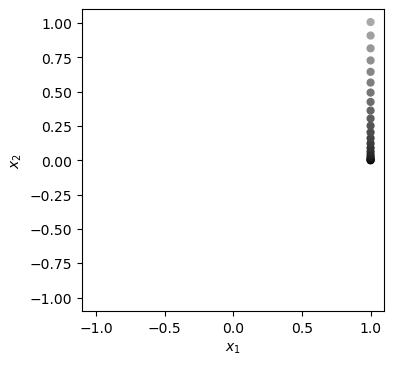

In [19]:

fig = MPP.figure(dpi = 100)
ax = fig.add_subplot(1,1,1,aspect = 'equal')
ax.scatter(y[0], y[1], s = 24 \
           , color = [(val, val, val) for val in 0.66*v_cval/NP.max(v_cval)] \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.set_xlim(NP.array([-1.1,1.1])*(constants[l]))
ax.set_ylim(NP.array([-1.1,1.1])*(constants[l]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
MPP.show();

# Kinetics / Inverse Dynamics

Assembling the usual balance equations. First in the static reference frame.

## In the Static Frame

Note that, compared to previous attempts in other notebooks, I changed the linear acceleration that enters the dynamic wrench. 
The correct one should be the acceleration of the pointmass (=COM) relative to the world origin. 

In [20]:
# dynamic force
dynamic_force_S = m* x[pointmass][origin][world][a]
SYM.pprint(PlugAllIn(dynamic_force_S).T)

# dynamic moment
dynamic_moment_S = I['S'][str(pointmass)]*ω[world][body][a] \
                    + ω[world][body][v].cross( I['S'][str(pointmass)]*ω[world][body][v] ) 
SYM.pprint(PlugAllIn(dynamic_moment_S).T)

# assembling the dynamic wrench (at the tip point)
dynamic_wrench_S = WT.Wrench.FromMatrices(world, pointmass, dynamic_force_S, dynamic_moment_S \
                       )

# because it was assembled at the center of mass, we must translate the wrench to the joint
dynamic_wrench_S = dynamic_wrench_S.Translate(joint)


PlugAllIn(dynamic_wrench_S.Matrix()).T

[0  0.1  0]
[0  0  0]


Matrix([[0, 0.1, 0, -0.05, 0, 0]])

The joint wrench is the one we want to determine.

In [21]:
force_components_S = SYM.symbols('f_{JS1:4}', real = True)
moment_components_S = SYM.symbols('m_{JS1:4}', real = True)

joint_wrench_S = WT.Wrench.FromComponents(world, joint, force_components_S, moment_components_S)

SYM.pprint(joint_wrench_S.Matrix().T)


[f_{JS1}  f_{JS2}  f_{JS3}  m_{JS1}  m_{JS2}  m_{JS3}]


And the Balance Equations are based on the conservation of momentum. 

In [22]:
# get the equations
equations_S = dynamic_wrench_S.Equate(joint_wrench_S) # simple?

# desired outcome variables
components_S =  [*force_components_S, *moment_components_S]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations_S \
                           , components_S \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_JS = WT.Wrench.FromMatrix(world, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_S]) )
SYM.pprint(PlugAllIn(W_JS.express(world).Matrix()).T)

[0  0.1  0  -0.05  0  0]


This is our reference calculation, giving us the Joint Wrench (i.e. force and moment) to expect when calculating the same wrench in the accelerating frames.

## In the Accelerated Frame
 
If one is interested in a net joint moment, and if any reference frame must be chosen for calculation, I would argue that it makes most sense to calculate with respect to the proximal adjacent segment. 
Consequently, let's imagine that we are an observer in the "arm" frame.

In [23]:
# dynamic force
dynamic_force_A = m* x[pointmass][shoulder][arm][a]
SYM.pprint(PlugAllIn(dynamic_force_A).T)

# dynamic moment
dynamic_moment_A = I['A'][str(pointmass)]*(trafo['A']['S'] * ω[world][body][a]) \
                    + (trafo['A']['S'] * ω[world][body][v]) \
                      .cross( I['A'][str(pointmass)]*(trafo['A']['S'] * ω[world][body][v]) ) 
SYM.pprint(PlugAllIn(dynamic_moment_A).T)

# assembling the dynamic wrench (at the tip point)
dynamic_wrench_A = WT.Wrench.FromMatrices(world, pointmass, dynamic_force_A, dynamic_moment_A \
                       )

# because it was assembled at the center of mass, we must translate the wrench to the joint
dynamic_wrench_A = dynamic_wrench_A.Translate(joint)


PlugAllIn(dynamic_wrench_A.Matrix()).T

[0  0  0]
[0  0  0]


Matrix([[0, 0, 0, 0, 0, 0]])

We get a zero dynamic wrench. 
This is consistent with our setting, because, when seen from the arm frame, the point mass does not move. 
Hence, its momentum appears to be constant.

In [24]:
force_components_A = SYM.symbols('f_{JA1:4}', real = True)
moment_components_A = SYM.symbols('m_{JA1:4}', real = True)

joint_wrench_A = WT.Wrench.FromComponents(arm, joint, force_components_A, moment_components_A)

SYM.pprint(joint_wrench_A.Matrix().T)


[f_{JA1}  f_{JA2}  f_{JA3}  m_{JA1}  m_{JA2}  m_{JA3}]


Lacking any other external forces, the only one to balance the dynamic wrench is the joint wrench. 

### (1) wrong approach:

One could naïvely ignore D'Alambert Force as I did before.

In [25]:
# get the equations
equations_A = dynamic_wrench_A.Equate(joint_wrench_A) # simple.

# desired outcome variables
components_A =  [*force_components_A, *moment_components_A]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations_A \
                           , components_A \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_JA = WT.Wrench.FromMatrix(arm, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_A]) )
SYM.pprint(PlugAllIn(W_JA.express(world).Matrix()).T)

[0  0  0  0  0  0]


This is obviously wrong; we would supposedly measure a force and moment at the joint. 

### (2) corrected:
Obviously, a D'Alambert Wrench is required.

The formula for D'Alamberts force is usually given by 
$F_D = -ma_{AS}$

So what is $a_{AS}$ (i.e. the linear acceleration of the arm frame in the static frame)?

To get such an acceleration, we must choose a point as the attachment point, and I selected the joint for this toy problem problem.

**Why did I select the joint?** First of all, because by selecting it I get a match between the static frame calculation and that in the accelerating frame. 
I interpret this as follows: a reasonable observer situated in $\{A\}$ might choose that joint as natural coordinate origin because it is the pivot of rotation of all points in the downstream segments. 
Because there is no rotation in this problem, one would get the same result when using the shoulder, i.e. the attachment of the arm itself. 
However, this might not generalize. 
I did not fully test it with more complex examples. 

And, to be honest, that "joint" is not the perfect choice either: it fails when calculating the joint wrench from within reference frames that are more than one segment apart (see the following notebook). 
I guess, but have not confirmed, that such a situation would require multiple D'Alambert components. 
Because that case is practically irrelevant, I did not pursue the tiny discrepancy and would be happy about audience participation (as in general).


A lot of consideration for the following simple wrench:

In [26]:
dalambert_wrench_A = WT.Wrench(arm, pointmass, MatrixToVector(-m*x[joint][origin][arm][a], arm ))

(Note the minus sign that goes with the mass.)

In [27]:
# get the equations
equations_A = dynamic_wrench_A.Equate(joint_wrench_A + dalambert_wrench_A) # simple.

# desired outcome variables
components_A =  [*force_components_A, *moment_components_A]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations_A \
                           , components_A \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_JA = WT.Wrench.FromMatrix(arm, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_A]) )
SYM.pprint(PlugAllIn(W_JA.express(world).Matrix()).T)

[0  0.1  0  -0.05  0  0]


This matches the Static Frame result. 


# Summary: D'Alambert Force
This simple example isolated the D'Alambert Force, i.e. the fictitious force which is due to linear acceleration of a reference frame. 
It also revealed that care must be taken which point to choose for reference frame attachment.

Yes, we need the D'Alambert Force! How could I forget it in the first place? 



<hr>

# Conceptual Answers

To conclude my series on fictitious forces, I will discuss some fundamental questions that repeatedly turned up on the way.

## How do we know that there are four and exactly four Fictitious Forces?

Maybe we don't. 
Maybe our universe does some weird thing in higher level integration, changing the momentum of things in proximity of big objects, and that is why we observe gravity. 
There is suspicious analogy in the formulas ($-mg$ *something*).
So who knows, maybe gravity is just a sort of fictitious force? 

After all, this is how physicists formalize fictitious forces: 
I read that when Léon Foucault observed precession of his pendulum, no responsible external force could be found, but angular momentum of the pendulum changed. 
Coriolis Force rectified this discrepancy, and because Coriolis force comes with a rotating frame, this was evidence for the rotation of the earth. 

Back to our question. 
**Are there more than the four fictitious forces? 
Probably no.** 
Remember the ["five accelerations" derivation](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank) linked in [the prequel notebook of this series](../id_lmx0b_fforces). 
That derivation captures all the possible forms of momentum for which we have evidence. 

Does that rule out unknown sources of momentum change? 
Please don't ask me, I'm a Biologist. 
Maybe it's good to keep an eye open! 


## Where to put the fictitious forces - LHS or RHS?
To re-iterate, when standing in a closed wagon of a linearly accelerating train, one would perceive a pull on the legs (or on the COM?) and conclude that there is a force changing momentum. 
After all, any change in momentum must be due to an external force, right? 

This leads me to a terminological observation. 
Remember the balance equation:

$\frac{d}{dt}(\text{momentum}) = W_{dyn} = \sum W_{ext} - \sum W_{fict}$

*The time change of linear|angular momentum of a rigid body is equal to the sum of external forces|moments acting on it.* Note the minus sign above emphasizes that all fictitious force formulas have a negative sign (which would be uncommon in a balance in accounting). 
The dynamic wrench in our balance equations is the measured change in momentum (LHS). External forces (RHS) are the cause of momentum change. 

Are fictitious forces a cause or an effect? 
By convention, fictitious forces are introduced on the right handside of the balance equation, with a negative sign. 
After having worked through my inverse dynamics examples, I would like to put it another way: 
the fictitious forces are compensation for a mis-judgement of the change of angular momentum, i.e. **there was some angular momentum change we could not balance with external forces.** 
Hence, I would put it this way: 

$\left(\frac{dp}{dt}\right)_{obs} + \left(\frac{dp}{dt}\right)_{fict} = \sum F_{ext}$

So the change of momentum that we observe in our frame of reference, plus the change of momentum which we do not attribute, is equal to the external forces acting on our system (which we could measure). 
It is a bit like a residual position in accounting balances, which can change to the side where it is most needed. 

And of course, the maths are indifferent to the choice of side, unless we make mistakes with the sign. 
I personally find the LHS arrangement (unnoticed momentum change) appealing with the goal of inverse dynamics in mind. 
It helped me sort out the issues I had in understanding these non-intuitive phenomena. 
The inversion of wording might equally help other students to understand what is going on. 

After all, fictitious forces are real; they are just a sophisticated lump for what could not be measured from an observer's limited perspective. 
Hence, the description as "unbalanced momentum change" might be accurate. 

But how *real* are they actually?

## Are fictitious forces real?

I had the false suspicion that conventional calculations of inverse dynamics are missing the fictitious forces, and would like to explain why, before relieving you from my false trail. 

Take the perspective of a muscle in the "rotating office chair" experiment I used to visualize the centrifugal force situation. 
Suppose you are biceps, and your purpose is to hold the lower arm of a spinning person upright, parallel to the rotation axis. 
You will feel tension, I bet!

And indeed, that tension is no fiction. It is real. 
It comes from the constant requirement to change the lower arm's angular momentum: instead of drifting of tangentially (the equivalent of constant momentum), that part of the system is held on a circular trajectory. 
Biceps, if it were the observer, might have a hard time to measure a change in momentum because it would take all kinematics relative to its own reference, which rotates with the point of interest. 
However, biceps would sense a force and might even produce a reaction force, thereby leading to the kinematics we tape on video as external observers. 
The forces are there. 
The momentum change is elusive. 

And that is the point. 
Static frame, theoretically, contains all the kinematics and thereby all momentum change. 

Yes, fictitious forces are real. 
And even better, **they are equally captured by static frame calculations.** 
A truly static reference frame is omniscient in a way, it has no "unnoticed momentum change". 
Hence, my misconception was not on fictitious forces, as I suspected. 
It was rather a misconception of the static frame calculation. 


This can also be explained the other way round: if the only external force is gravity, and we would believe it is there and know the mass of a rigid body of interest, we could perfectly pinpoint the right hand side ($F_{ext} = F_g$). 
From a static reference frame, we would see the COM accelerate, which gives a dynamic wrench, which accurately captures the change in momentum. 
Now consider being an observer within the falling object ("physicist in elevator" example). 
The COM does not move from our perspective. 
If we know from experience that there is a certain gravity, but observe inconsistent kinematics, then we must conclude that momentum is being changed without notice. 


I initially had the idea to be able to calculate the contribution of the fictitious forces, and at the very least find out whether their magnitude is negligible in the systems we study. 
I now understood that the magnitude does not even matter. 
And, I have to acknowledge, my supervisor Peter told me so from the start. 
But I think we both enjoyed the detour. 

## Will the arm in this example bend, i.e. will the point mass start to rotate around the joint, or will it stay upright?

That is not a question of inverse dynamics. 
It would be a question of forward dynamics modeling. 
In inverse dynamics, we observe a motion, thus measure the dynamic wrench, and calculate joint wrenches necessary to produce the motion.

For example, in the setting above, I assume that the joints will produce any wrench necessary to keep the pointmass in relative place. 

In contrast to that, forward dynamics would model the right hand side, and attempt to predict the momentum change of objects. 

## What happens if we ignore some external forces?

This is a conceptual question I had since early on. 
If we ignore air drag, for example, what happens to our balance of moments? 

$W_{dyn} = W_{J} + \sum W_{other}$

Well, the inverse dynamics strategy has the following in- and outputs:
- $W_{dyn}$ is known by measurement
- $W_{J}$ is what we are interested in
- $W_{other}$ are model components, known *in theory*.

The critical part is $W_{other}$. 
Imagine we would assume the gravitational acceleration to be $10 m s^{-2}$. 
Perfectly accurate for all practical piglet purposes. 
Now if someone said $9.81 m s^{-2}$, this would decrease our gravitational wrench, and because LHS is fixed, we would yield a too low or high joint moment (depending on signs), and in consequence wrongly estimating muscle work. 
If we ignore air drag, we underestimate net joint moments in phases where the limb is accelerating, and overestimate the decelerating joint moments. 

This is important to keep in mind when discussing which external forces can be included, and which can't. 


When I initially missed out on D'Alambert force, I calculated wrong joint moments in the accelerated frames, adjusting both sides of the equations to get the checks right. 
Then, I migrated the LHS (dynamic wrench) adjustment to the static frame, and alse got wrong results there. 
They say here in Flanders that "proberen is leren", trying is learning. 
I can relate to that saying. 


# Summary: Elementary Examples of Inverse Dynamics

The questions and answers above have nullified the suspicions which led me on the path to explore fictitious forces in inverse dynamics. 
But to me that felt like good science: try to falsify the status quo, and on the way learn to appreciate the excellent work of your predecessors. 
If all goes well, I can now build on it with less mistakes than I would have done otherwise. 

To recapture: 
- Balance Equations are the mathematical manifestation of conservation of momentum.  
- Fictitious Forces are unbalanced change of momentum. 
- Static frame calculations result in correct joint moments. 
- If you want to calculate balances in an accelerating frame, include four fictitious forces: D'Alambert, Euler, Coriolis, Centrifugal. 
- Wrenches are a useful computational tool for the procedure. 

I hope you enjoyed working through the exercises I presented in this series.

Or, if not enjoy, then maybe you at least felt empathy for some "εὕρηκα!" moments I had while preparing them. 
I would be happy if you find some purpose for the universal workflow and the elementary examples, for example if you intend to calculate inverse dynamics yourself and need elementary cases to test your algorithms. 

Or you are up for a discussion. 
Those are the comments I enjoy most. 
So don't hesitate to object, please.

Questions and feedback are welcome (use the "contact" page in the menu or send me an e-mail). 

One [more notebook follows](../id_lmx5_nlink) which wraps up the code for application on an n-link limb.

<hr> 

# References

- **Dumas**, R., Aissaoui, R., & de Guise, J. A. (**2004**). *A 3D generic inverse dynamic method using wrench notation and quaternion algebra.* Computer methods in biomechanics and biomedical engineering, 7(3), 159-166. [https://doi.org/10.1080/10255840410001727805](https://doi.org/10.1080/10255840410001727805?target=_blank)

- **Dumas**, R. (**2019**). *3D Kinematics and Inverse Dynamics* , [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/58021-3d-kinematics-and-inverse-dynamics?target=_blank). Accessed July 1, 2020. 

- **Lynch**, K. M., & Park, F. C. (**2017**). *Modern Robotics.* Cambridge University Press. ISBN 9781107156302. [http://www.modernrobotics.org](http://www.modernrobotics.org?target=_blank) 

- **Meurer** A., Smith C.P., Paprocki M., Čertík O., Kirpichev S.B., Rocklin M., Kumar A., Ivanov S., Moore J.K., Singh S., Rathnayake T., Vig S., Granger B.E., Muller R.P., Bonazzi F., Gupta H., Vats S., Johansson F., Pedregosa F., Curry M.J., Terrel A.R., Roučka Š., Saboo A., Fernando I., Kulal S., Cimrman R., Scopatz A. (**2017**). *SymPy: symbolic computing in Python.* PeerJ Computer Science 3:e103 [https://doi.org/10.7717/peerj-cs.103](https://doi.org/10.7717/peerj-cs.103?target=_blank)

- **Moore**, J., McMurry, R., Milam, B. (**2016**). *Simulating Robot, Vehicle, Spacecraft, and Animal Motion.* SciPy 2016 Tutorial. [https://www.youtube.com/watch?v=r4piIKV4sDw](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank). Accessed July 1, 2020.

- **Owen**, F. (undated). *Rotating reference frame and the five-term acceleration equation*. Alpha Omega Engineering, Inc. [web document](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank). Accessed July 1, 2020.